# PharmSci 175/275 (UCI)
## What is this?? 
The material below is a lecture on solvation models from Drug Discovery Computing Techniques, PharmSci 175/275 at UC Irvine. 
Extensive materials for this course, as well as extensive background and related materials, are available on the course GitHub repository: [github.com/mobleylab/drug-computing](https://github.com/mobleylab/drug-computing)

This material is a set of slides intended for presentation with RISE as detailed [in the course materials on GitHub](https://github.com/MobleyLab/drug-computing/tree/master/uci-pharmsci/lectures/energy_minimization). While it may be useful without RISE, it will also likely appear somewhat less verbose than it would if it were intended for use in written form.

# Solvation models

Today: Solvation models for molecular simulation; implicit solvent; how solvent affects simulations.

### Instructor: David L. Mobley

### Contributors to today's materials:
- David L. Mobley

## Solvation is key for biomolecular structure and function, accuracy in modeling

- Imagine improving a molecule's interactions with a receptor but suffering loss in binding affinity. Why might this happen?
- Solvation modeling is also important for docking
- Biology takes place in solution (lots of water)
- Simulations spend a large fraction of time simulating solvent

Why lose affinity with improved interactions? Can happen because improved interactions don't offset increased desolvation penalty. e.g. ions overstabilized without desolvation destimates.

## Continuum solvent models can be understood starting from classical E&M

Imagine a positive charge approaching a conducting plane; the solution looks like this:

<center><img src="images/image_charge.png" alt="GitHub" style="width: 600px;"/></center>

A conducting plane has a dielectric constant ($\epsilon$) of infinity. Solvents, especially high dielectric ones like water, behave somewhat similarly in terms of electrostatic (charge-charge) interactions.

## We can also describe solvation of charges in solution using classical E&M

- Key goal: Capture average or integrated behavior of solvent
- Could work reasonably well for high dielectric solvents
- Ignores molecularity of solvent

<center><img src="images/born.png" alt="GitHub" style="width: 600px;"/></center>


## There are various levels of solvation models

Computational cost increases down the list; physical rigor highest at top:
- _Ab initio QM_ (cost prohibitive)
- Polarizable explicit solvent
- Fixed charge explicit-solvent
- Nonlinear Poisson-Boltzmann (PB)
- Linear Poisson-Boltzmann (PB)
- Generalized Born
- ...
- Distance dependent dielectric, surface area models

### Some efforts attempt to jump off this trend
- Improved GB models
- Hybrid solvent models
In general -- using clever numerics to take better physics and make it fast (e.g. via lookup tables, etc.)

### PB models water as a continuum dielectric

- Essentially exact _within_ a continuum solvent model/classical E&M
- Ignores granularity/structure of water such as first-solvation shell effects, size of water
- Numerical solution requires approximations

<center><img src="images/born.png" alt="GitHub" style="width: 300px;"/></center>

### PB starts with the Poisson equation

$\nabla \cdot \epsilon({\bf r}) \nabla \phi({\bf r}) = -4\pi \rho({\bf r})$

where
- $\phi({\bf r})$  is the electrostatic potential
- $\epsilon({\bf r})$ is the dielectric constant (varies with position); often 80 (water) outside, 1 inside molecules
- $\rho({\bf r})$ is the charge density; partial charges inside, zero or ions outside

## The Debye-Huckel model describes ion screening

<right><img src="images/debye_huckel.png" alt="Debye-Huckel" style="width: 300px;"/></right>

$\rho_i({\bf r}) = \rho_i^0 e^{-q_i \phi({\bf r})/(k_B T)}$ where $\rho_0^i$ is the ion density in bulk

This leads to enrichment of ions in regions of opposing electrostatic potential.

For a 1:1 salt, $\rho_{ionic}({\bf r}) = \rho_+({\bf r}) + \rho_-({\bf r}) = \rho^0 e^{ \phi({\bf r})/(k_B T)} -\rho^0 e^{ \phi({\bf r})/(k_B T)} = 2\rho^0 \sinh (\frac{\phi({\bf r})}{k_B T})$

## The linearized PB equation is good for small electrostatic potential

We start with $\nabla \cdot \epsilon({\bf r}) \nabla \phi({\bf r}) - \kappa \sinh( \phi({\bf r}) = -4\pi \rho({\bf r})$
we can Taylor expand the ionic strength term involving $\kappa$ for small fields, taking the first term, which gives:

$\nabla \cdot \epsilon({\bf r}) \nabla \phi({\bf r}) - \kappa \phi({\bf r}) = -4\pi \rho({\bf r})$

This is the linearized form, good for small fields but not highly charged cases.

### Solution is numeric

- Solved via a finite difference scheme on a grid
- Distribute charges onto a grid
- Find dielectric at each point
- Value of field at each point depends on neighboring points, so solve iteratively

### The dielectric constant itself is a challenge

- What is the internal dielectric constant of a protein or solute? Tough question. Maybe 2-4?
- Some pKa work and experiments suggest maybe higher, as high as 20?
- Could include conformational relaxation, protonation state changes, as well as electronic polarization
- Some of that shouldn't be included
- Simulations usually use a value of 1, but some efforts vary depending on polarizability of atoms

Inside vs outside is also complex, determined by radius of atoms (often adjustable)

### PB calculations have several uses

- Visualization of electrostatic potential (e.g. in PyMol [with APBS](https://pymolwiki.org/index.php/APBS) or [Delphi](http://www.protein.osaka-u.ac.jp/rcsfp/supracryst/suzuki/jpxtal/Katsutani/en/potential.php) (see also [here](http://structure.usc.edu/howto/delphi-surface-pymol.html)) or Chimera)
- Predicting protein-protein association rates (e.g. [TransComp](http://pipe.sc.fsu.edu/transcomp/))
- Fitting of more approximate models
- pKa estimation

<p float="left">

<img  align="left" src="http://pipe.sc.fsu.edu/transcomp/img/ProtAssocRates.png" alt="TransComp" style="width: 500px;"/> <img align="right" src="images/1W2I.png" alt="TransComp" style="width: 300px;"/></p>

### Protonation states depend substantially on environment
- Effective pKa values depend on environnment
- Classical force fields have no reactions, so charges usually stay fixed
- That means we take significant care in determining protonation states suitable for pH we want
- Exception: Constant pH simulations
- pKa prediction estimates free energy shifts in macromolecule relative to model system (e.g. sidechain analog in isolation), uses to predict pKa shift

### PB is not normally used for simulations

- MD requires gradients (forces); forces are not easy or fast to get from PB
- But used for scoring simulations and docking
- Used to help understand binding/mutagenesis
- Other applications such as protein-protein interactions (above)

## Generalized born is an approximation to PB that IS commonly used for simulations

- Useful for simulations; derivatives are easy to get, can yield fast MD simulations and minimization
- To some extent behaves like PB (but approximate)
- Hard to understand exactly what approximations it makes
- Has deficiencies PB does not
- But also has same deficiencies (e.g. both ignore size/molecularity of water)

### GB has roughly the right limits

- For solvation of a single ion, reduces to the well-known [Born equation](https://en.wikipedia.org/wiki/Born_equation) for ion solvation: $\Delta G = -\frac{N_a z^2 e^2}{8 \pi \epsilon_0 r_0} \left( 1 - \frac{1}{\epsilon_r}\right)$
- For large distances, get complete screening: Screening exactly cancels Coulomb's law attraction
- Correct in certain other cases, such as dipoles inside spheres

### In both PB and GB, the surface plays a huge role
The surface describes where the dielectric constant changes: Inside versus outside
- Molecular surface: Roll a solvent probe on the surface
- Van der Waals surface: Intersection of vdW spheres
- Gaussian surface: Take surface as continuum or isocontour

The surface can be problematic for dynamics, especially in the first two cases; can change discontinuously yielding sudden dramatic changes in energies/forces and thus crashes.

### Solvation involves a nonpolar component as well

- The cavity creation part is often assumed to be dominant
- On the smallest length scales this is probably $\propto V$, the solute volume
- At large length scales it amounts to bubble creation, scales with solute surface area
- So often assumed to be $\propto SA$ plus a constant

## Implicit solvent models ignore the molecular nature of water

Consider two artificial ring-shaped solutes; compute the hydration free energy in explicit solvent (TIP3P water) ([this work](http://dx.doi.org/10.1021/jp709958f):
<img src="images/rings.png">

The difference is an _asymmetry_ between positive and negative; $\approx -9.6$ kcal/mol

In implicit solvent the hydration free energies are equal (though clever follow-ups have done some work to deal with this, see e.g. work of Purisima and of Onufriev)

### Ultimately this is due to water's structure; it is not a dielectric continuum microscopically

<img src="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jpcbfk/2008/jpcbfk.2008.112.issue-8/jp709958f/production/images/large/jp709958ff00002.jpeg" width="800px">

### Water has a non-symmetric shape and responds to charge asymmetrically

<img src ="https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jpcbfk/2008/jpcbfk.2008.112.issue-8/jp709958f/production/images/large/jp709958ff00003.jpeg" width="600px">

# Could add more slides here on asymmetry

# Let's look at how solvation impacts conformation and flexibility

- We saw gas phase MD recently
- What about MD in implicit solvent?
- Let's look at how solvation impacts conformation of some simple molecules
- [This study](http://dx.doi.org/10.1021/jp0764384) highlighted some molecules which change conformation or flexibility on going into solvent
- In that paper, SI Table 2 highlights molecules which change flexibility a lot on going into solvent
- Figure 5 highlights some cases where molecules may change conformation going into solvent

From those it looks like it might be interesting to try 1,2-diacetoxyethane (SMILES `C(CO)O`) and 2-chloroethyl ether (SMILES `CC(=O)OCCOC(=O)C`)

## First we'll pull the code we used in the MD sandbox for gas phase MD simulations

Let's make this into a bit of a function so we can re-use it in case we want to simulate both molecules. We'll make our function take an argument about how long to run, and produce some named output files.

### Here's our function definition

In [17]:
from openforcefield.typing.engines.smirnoff import *
from openforcefield.topology import Molecule, Topology
import openforcefield.utils.structure as structure
from simtk import openmm, unit
import os, time
import parmed

def gas_phase_MD(oemol, nsteps, outprefix='molecule'):
    """Run gas phase MD on a molecule using the SMIRNOFF force field and Langevin dynamics in OpenMM
for a specified number of steps, writing output trajectory/coordinate files to the specified prefix.
Trajectory snapshots will be stored to a NetCDF file every 100 frames.

    Arguments:
    _________
        oemol: (OpenEye OEMol object)
            OpenEye OEMol of the molecule to simulate. Must have all hydrogens and have 3D conformation.
        nsteps: integer
            Number of 2 femtosecond timesteps to take
        outprefix (optional, default 'molecule'): string
            Prefix for output files (trajectory/Topology/etc.).
    Returns:
    ________
        status: (bool)
            True/False depending on whether task succeeded
        system: (OpenMM System)
            system as simulated
        topology: (OpenMM Topology)
            Topology for system
        positions: (simtk.unit position array)
            final position array
        
    """
    # Create OpenFF Molecule from oemol
    offmol = Molecule.from_openeye(oemol)
    
    # Prep forcefield, create system and Topology
    ff = ForceField('openff-1.0.0.offxml')
    topology = Topology.from_molecules([offmol])
    system = ff.create_openmm_system(topology)

    positions = structure.extractPositionsFromOEMol(oemol)
    
    # Energy minimize
    # Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
    integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
    # Prep the Simulation using the parameterized system, the integrator, and the topology
    simulation = openmm.app.Simulation(topology, system, integrator)
    # Copy in the positions
    simulation.context.setPositions( positions) 

    # Get initial state and energy; print
    state = simulation.context.getState(getEnergy = True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    #print("Energy before minimization (kcal/mol): %.2g" % energy)

    # Minimize, get final state and energy and print
    simulation.minimizeEnergy()
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    #print("Energy after minimization (kcal/mol): %.2g" % energy)
    newpositions = state.getPositions()
    
    from mdtraj.reporters import NetCDFReporter
    integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

    # Prep Simulation
    simulation = openmm.app.Simulation(topology, system, integrator)
    # Copy in minimized positions
    simulation.context.setPositions(newpositions)

    # Initialize velocities to correct temperature
    simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
    # Set up to write trajectory file to NetCDF file in data directory every 100 frames
    netcdf_reporter = NetCDFReporter(os.path.join('.', '%s.nc' % outprefix), 100) #Store every 100 frames
    # Initialize reporters, including a CSV file to store certain stats every 100 frames
    simulation.reporters.append(netcdf_reporter)
    simulation.reporters.append(openmm.app.StateDataReporter(os.path.join('.', '%s.csv' % outprefix), 100, step=True, potentialEnergy=True, temperature=True, density=True))

    # Run the simulation and print start info; store timing
    print("Starting simulation")
    start = time.clock()
    simulation.step(nsteps) 
    end = time.clock()

    # Print elapsed time info, finalize trajectory file
    print("Elapsed time %.2f seconds" % (end-start))
    netcdf_reporter.close()
    print("Done!")
    
    # Get state
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    
    # Write out a PDB
    from simtk.openmm.app import PDBFile
    openmm_topology = topology.to_openmm()
    with open(outprefix+'.pdb', 'w') as outfile:
        PDBFile.writeFile(openmm_topology, state.getPositions(), outfile)
    
    # Return
    return True, system, topology, state.getPositions()

### Let's test it out: We'll start by prepping our two molecules

In [18]:
# What SMILES string for our molecules? Should be isomeric SMILES
mol_smiles_strings = ['C(CO)O', 'CC(=O)OCCOC(=O)C']

# Import stuff
from openeye.oechem import *
import oenotebook as oenb
from openeye.oeomega import * # conformer generation
from openeye.oequacpac import * #for partial charge assignment

# Create empty OEMols, convert, and save
my_molecules = []
for mol_smiles in mol_smiles_strings:
    mol = OEMol()
    # Convert SMILES and store
    OESmilesToMol(mol, mol_smiles)
    my_molecules.append(mol)

### Now generate conformers for our molecules

In [19]:
#initialize omega for conformer generation
omega = OEOmega()
omega.SetMaxConfs(1) #Generate only a single conformer
omega.SetIncludeInput(False)
omega.SetStrictStereo(False) #Pick random stereoisomer if stereochemistry not provided

# Set up to store molecules after conformers generated/charged
final_molecules = []

for mol in my_molecules:
    # Set to use a simple neutral pH model 
    OESetNeutralpHModel(mol)
    # Generate conformers with Omega; keep only best conformer
    status = omega(mol)
    if not status:
        print("Error generating conformers." )
    
    final_molecules.append(OEMol(mol))

### Now we run our function on those two molecules

In [26]:
# 10000 steps (on these systems) is good for a test and will generate reasonable plots; 100000 steps will give you really quite solid data
status1, system1, topology1, positions1 = gas_phase_MD(final_molecules[0], 100000, outprefix='test1')
status2, system2, topology2, positions2 = gas_phase_MD(final_molecules[1], 100000, outprefix='test2')

Starting simulation


/Users/dmobley/anaconda3/envs/drugcomp/lib/python3.7/site-packages/ipykernel_launcher.py:81: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/dmobley/anaconda3/envs/drugcomp/lib/python3.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Elapsed time 25.48 seconds
Done!
Starting simulation
Elapsed time 29.03 seconds
Done!


## Now let's make an alternate function which does the same thing, but in implicit solvent


Basically we just need the same function as above, but with the addition of Generalized Born (GB) implicit solvent parameters.

In [27]:
from io import StringIO

def GBSA_MD(oemol, nsteps, outprefix='molecule'):
    """Run GBSA (OBC1) MD on a molecule using the SMIRNOFF force field and Langevin dynamics in OpenMM
for a specified number of steps, writing output trajectory/coordinate files to the specified prefix.
Trajectory snapshots will be stored to a NetCDF file every 100 frames.

    Arguments:
    _________
        oemol: (OpenEye OEMol object)
            OpenEye OEMol of the molecule to simulate. Must have all hydrogens and have 3D conformation.
        nsteps: integer
            Number of 2 femtosecond timesteps to take
        outprefix (optional, default 'molecule'): string
            Prefix for output files (trajectory/Topology/etc.).
    Returns:
    ________
        status: (bool)
            True/False depending on whether task succeeded
        system: (OpenMM System)
            system as simulated
        topology: (OpenMM Topology)
            Topology for system
        positions: (simtk.unit position array)
            final position array
        
    """
    
    # Get implicit solvent parameters ready
    GB_xml_string = u"""\
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <Date>2019-08-08</Date>
    <Author>J. Chodera, (MSKCC); J. Wagner (Open Force Field)</Author>
    <!-- This file is intended to replicate the settings and per-particle parameters provided by OpenMM's customgbforces.GBSAHCTForce class -->
    <GBSA version="0.3" gb_model="HCT" solvent_dielectric="78.5" solute_dielectric="1" sa_model="ACE" surface_area_penalty="5.4*calories/mole/angstroms**2" solvent_radius="1.4*angstroms">
      <Atom smirks="[*:1]" radius="0.15*nanometer" scale="0.8"/>
      <Atom smirks="[#1:1]" radius="0.12*nanometer" scale="0.85"/>
      <Atom smirks="[#1:1]~[#6]" radius="0.13*nanometer" scale="0.85"/>
      <Atom smirks="[#1:1]~[#7]" radius="0.13*nanometer" scale="0.85"/>
      <Atom smirks="[#1:1]~[#8]" radius="0.08*nanometer" scale="0.85"/>
      <Atom smirks="[#1:1]~[#16]" radius="0.08*nanometer" scale="0.85"/>
      <Atom smirks="[#6:1]" radius="0.17*nanometer" scale="0.72"/>
      <Atom smirks="[#7:1]" radius="0.155*nanometer" scale="0.79"/>
      <Atom smirks="[#8:1]" radius="0.15*nanometer" scale="0.85"/>
      <Atom smirks="[#9:1]" radius="0.15*nanometer" scale="0.88"/>
      <Atom smirks="[#14:1]" radius="0.21*nanometer" scale="0.8"/>
      <Atom smirks="[#15:1]" radius="0.185*nanometer" scale="0.86"/>
      <Atom smirks="[#16:1]" radius="0.18*nanometer" scale="0.96"/>
      <Atom smirks="[#17:1]" radius="0.17*nanometer" scale="0.8"/>
    </GBSA>
</SMIRNOFF>"""
    GB_xml = StringIO(GB_xml_string)
    
    # Prep forcefield, create system and Topology
    ff = ForceField('openff-1.0.0.offxml', GB_xml)
    # Create OpenFF Molecule from oemol
    offmol = Molecule.from_openeye(oemol)
    
    topology = Topology.from_molecules([offmol])
    system = ff.create_openmm_system(topology)

    positions = structure.extractPositionsFromOEMol(oemol)


    
    # Energy minimize
    # Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
    integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
    # Prep the Simulation using the parameterized system, the integrator, and the topology
    simulation = openmm.app.Simulation(topology, system, integrator)
    # Copy in the positions
    simulation.context.setPositions( positions) 

    # Get initial state and energy; print
    state = simulation.context.getState(getEnergy = True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    #print("Energy before minimization (kcal/mol): %.2g" % energy)

    # Minimize, get final state and energy and print
    simulation.minimizeEnergy()
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
    #print("Energy after minimization (kcal/mol): %.2g" % energy)
    newpositions = state.getPositions()
    
    from mdtraj.reporters import NetCDFReporter
    integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

    # Prep Simulation
    simulation = openmm.app.Simulation(topology, system, integrator)
    # Copy in minimized positions
    simulation.context.setPositions(newpositions)

    # Initialize velocities to correct temperature
    simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
    # Set up to write trajectory file to NetCDF file in data directory every 100 frames
    netcdf_reporter = NetCDFReporter(os.path.join('.', '%s.nc' % outprefix), 100) #Store every 100 frames
    # Initialize reporters, including a CSV file to store certain stats every 100 frames
    simulation.reporters.append(netcdf_reporter)
    simulation.reporters.append(openmm.app.StateDataReporter(os.path.join('.', '%s.csv' % outprefix), 100, step=True, potentialEnergy=True, temperature=True, density=True))

    # Run the simulation and print start info; store timing
    print("Starting simulation")
    start = time.clock()
    simulation.step(nsteps) 
    end = time.clock()

    # Print elapsed time info, finalize trajectory file
    print("Elapsed time %.2f seconds" % (end-start))
    netcdf_reporter.close()
    print("Done!")
    
    # Get state
    state = simulation.context.getState(getEnergy=True, getPositions=True)
    
    # Write out a PDB
    from simtk.openmm.app import PDBFile
    openmm_topology = topology.to_openmm()
    with open(outprefix+'.pdb', 'w') as outfile:
        PDBFile.writeFile(openmm_topology, state.getPositions(), outfile)
    
    # Return
    return True, system, topology, state.getPositions()
    


### Now we run our function on the two molecules again

We don't need to re-generate molecules/starting coordinates

In [28]:
status1, system1, topology1, positions1 = GBSA_MD(final_molecules[0], 100000, outprefix='test1_GB')
status2, system2, topology2, positions2 = GBSA_MD(final_molecules[1], 100000, outprefix='test2_GB')

Starting simulation


/Users/dmobley/anaconda3/envs/drugcomp/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Users/dmobley/anaconda3/envs/drugcomp/lib/python3.7/site-packages/ipykernel_launcher.py:106: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Elapsed time 41.16 seconds
Done!
Starting simulation
Elapsed time 41.95 seconds
Done!


## Now let's analyze the results in both cases and see if solvent is making a difference

### We'll start with the first molecule, in the gas phase case

Here, let's visualize the molecule, then decide some properties to compute.
For visualization we'll take out rotational and translational motion.

In [29]:
import mdtraj
import nglview
traj= mdtraj.load(os.path.join('.', 'test1.nc'), top=os.path.join('.', 'test1.pdb'))
# Take out rotational/translational motion by superimposing on itself for easier viewing
traj.superpose(traj)

# View the trajectory
view = nglview.show_mdtraj(traj)
view

NGLWidget(count=1000)

### On to the implicit solvent case

In [30]:
import mdtraj
import nglview
traj2= mdtraj.load(os.path.join('.', 'test1_GB.nc'), top=os.path.join('.', 'test1_GB.pdb'))
# Take out rotational/translational motion by superimposing on itself for easier viewing
traj2.superpose(traj2)

# View the trajectory
view = nglview.show_mdtraj(traj2)
view

NGLWidget(count=1000)

### What did we observe? 

- In gas phase, the two polar hydrogens usually point the same direction; not in GB
- Transitions in the orientation of the hydrogens are faster in GB
- The molecule may be more extended more often in GB

### Now let's compute some properties to see if we can back that up quantitatively

If the two hydrogens usually point in the same direction in gas phase but not in GB, that means the distance between them should be smaller in gas phase than in GB (because they never get to the extended conformation shown below). 

So let's compute and graph the distance between protons.

<img src ="images/extended.png" width="400px">

Populating the interactive namespace from numpy and matplotlib


/Users/dmobley/anaconda3/envs/drugcomp/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Arrow', 'Text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


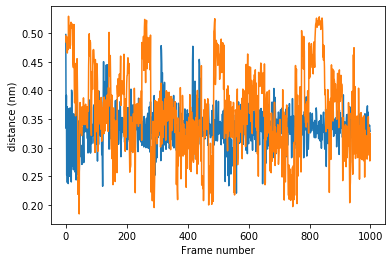

In [33]:
# Let's extract and graph the distances between the hydroxyl protonsfor the first molecule, 1,2-ethanediol
topology1 = traj.topology
# I opened the molecule in a viewer and manually input the indices of the hydrogen atoms, less 1 (python indexing)
hydrogen_pair = [8, 9]
dists1 = mdtraj.compute_distances(traj, [hydrogen_pair])

dists2 = mdtraj.compute_distances(traj2, [hydrogen_pair])

%pylab inline
figure()
plot(dists1)
plot(dists2)
ylabel(r'distance (nm)')
xlabel('Frame number')
show()

#### So it looks like the GB case indeed has a higher distance; let's do a histogram to see it better

In [34]:
# To see your atom names you could use this (though we'd actually need to get OpenFF to assign names first, above)
for atom in topology1.atoms: 
    print(atom.name, atom.index)

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9


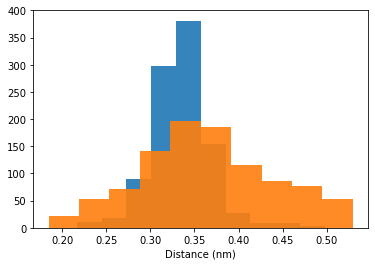

In [35]:
figure()
hist(dists1, alpha=0.9) #The alpha value makes the histograms semi-transparent
hist(dists2, alpha=0.9) 
xlabel(r'Distance (nm)')
show()

### We also thought transitions in the orientations of the hydrogens are faster in GB

Let's look at the torsional angles for the hydroxyls to see if we can observe a difference

Text(0.5, 1.0, 'Gas phase trajectory')

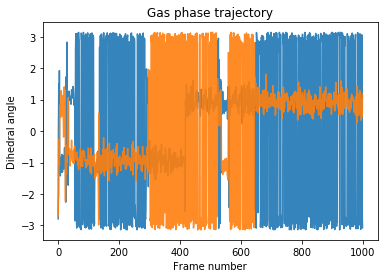

In [36]:
dihedral1_atoms=[1, 0, 2, 8] # I pulled these from the names of the atoms, printed using code above
dihedral2_atoms=[0, 1, 3, 9]

dihedrals1 = mdtraj.compute_dihedrals( traj, [dihedral1_atoms, dihedral2_atoms])
dihedrals2 = mdtraj.compute_dihedrals( traj2, [dihedral1_atoms, dihedral2_atoms])
figure()
plot(dihedrals1[:,0], alpha=0.9)
plot(dihedrals1[:,1], alpha=0.9)
xlabel('Frame number')
ylabel('Dihedral angle')
title('Gas phase trajectory')

#### GBSA case

Text(0.5, 1.0, 'Water trajectory')

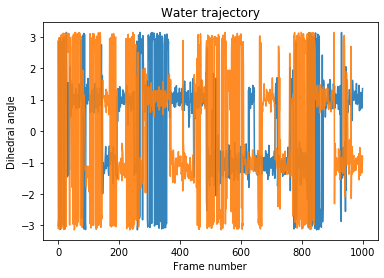

In [37]:
figure()
plot(dihedrals2[:,0], alpha=0.9)
plot(dihedrals2[:,1], alpha=0.9)
xlabel('Frame number')
ylabel('Dihedral angle')
title('Water trajectory')

It seems like there may be more transitions, though if so, it's somewhat subtle. But it also seems to be that the GBSA case spends more time in the state near 2 radians. 

### We also thought we observed that the two hydrogens have directions which are less correlated in GB

Another way to check this would be to actually compute the correlation in the torsional angles in the two cases. Let's do that.

In [38]:
# Compute correlation for gas phase case
correlation1 = np.correlate( dihedrals1[:,0], dihedrals1[:,1])
# Compute correlation for GB case
correlation2 = np.correlate( dihedrals2[:,0], dihedrals2[:,1])
print(correlation1, correlation2)

[-44.030907] [-212.58937]


So indeed it looks like the torsional angles are less correlated in the GB case than in the gas phase case, supporting the observation that the protons don't have to point in the same direction in GB.

### As a final check, let's compute the radius of gyration, $R_g$, a measure of size

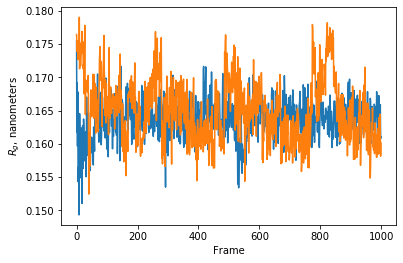

In [39]:
g1 = mdtraj.compute_rg(traj)
g2 = mdtraj.compute_rg(traj2)
figure()
plot(g1)
plot(g2)
xlabel('Frame')
ylabel(r'$R_g$, nanometers')
show()

## Now let's take a look at our other molecule

We'll do a bit less analysis here for brevity, but let's start off with a visualization of the two cases again.

In [40]:
import mdtraj
import nglview
traj3= mdtraj.load(os.path.join('.', 'test2.nc'), top=os.path.join('.', 'test2.pdb'))
# Take out rotational/translational motion by superimposing on itself for easier viewing
traj3.superpose(traj3)

# View the trajectory
view = nglview.show_mdtraj(traj3)
view

NGLWidget(count=1000)

In [41]:
import mdtraj
import nglview
traj4= mdtraj.load(os.path.join('.', 'test2_GB.nc'), top=os.path.join('.', 'test2_GB.pdb'))
# Take out rotational/translational motion by superimposing on itself for easier viewing
traj4.superpose(traj4)

# View the trajectory
view = nglview.show_mdtraj(traj4)
view

NGLWidget(count=1000)

### We could do a lot of the same analysis here

We could do a lot of the same analysis in this case. I don't think I see anything super obvious in the visualization, and this is not a case (like the diol above) where there will be particularly strong internal electrostatic interactions, so we may see less. 

For now, let's just look at the radius of gyration as a simple proxy.

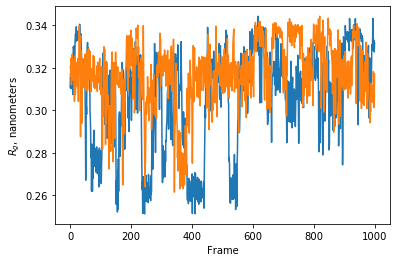

In [42]:
g3 = mdtraj.compute_rg(traj3)
g4 = mdtraj.compute_rg(traj4)
figure()
plot(g3)
plot(g4)
xlabel('Frame')
ylabel(r'$R_g$, nanometers')
show()

### Well, that sure doesn't show much

Perhaps the radius of gyration is just not a good measure here, as that looks very inconclusive. What about if we look at root mean squared distance (RMSD) from the starting conformation?

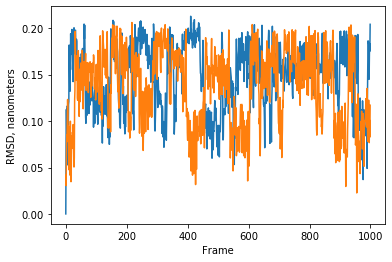

In [43]:
r3 = mdtraj.rmsd(traj3, traj3[0])
r4 = mdtraj.rmsd(traj4, traj3[0])
figure()
plot(r3)
plot(r4)
xlabel('Frame')
ylabel(r'RMSD, nanometers')
show()

### That doesn't seem to show much either.

So far, it doesn't seem like we see see much for this case. The RMSD calculation does show some structural transitions, but it's not super obvious that the GB case has dramatically more flexibility.

The previous study (noted above) does indicate that on longer timescales, there is somewhat more flexibility in solution than in gas phase for this case, as indicated by a significant change in entropy on transfer to solution. However, here, our tests are on a significantly shorter timescale and we seem not yet to have enough data that it shows up structurally. 